In [1]:
__author__ = 'Robert Dzudzar <robertdzudzar@gmail.com>, <rdzudzar@swin.edu.au>; Robert Nikutta <robert.nikutta@noirlab.edu>'
__version__ = '20240531' # yyyymmdd; version datestamp of this notebook
__keywords__ = ['extragalactic', 'interactive plot', 'spectra', 'galaxies','image cutout']

# Interactively examining the HI Parkes All Sky Survey (HIPASS)
*Robert Dzudzar*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)  

* #### [Import HIPASS data](#chapter1)
    * [Plot the Sky coverage of the HIPASS survey](#chapter1.1)
    * [Choose dataset to visuelise](#chapter1.2)
    * [Scraping url-s where the data of the HIPASS spectra is storred](#chapter1.3)
    * [Creating list of HIPASS sources](#chapter1.4)
    * [Extracting spectral information from HIPASS database](#chapter1.5)
    * [Plotting the HI spectra for each source](#chapter1.6)  

* #### [Query optical counterparts of the HIPASS sources](#chapter2)
    * [Create a list of coordinates](#chapter2.1)
    * [Download and save images from SkyView](#chapter2.2)  

* #### [Setting up Bokeh for interactive examination](#chapter3)
    * [Extracting images and spectra](#chapter3.1)
    * [Approximate Distance and HI mass](#chapter3.2)  

* #### [Interactive visualization with Bokeh](#chapter4)  


* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is for interactive exploration of the multiwavelength data, in particular: a combination of the radio data (measured properties and HI emission line spectra) from the HI Parks All Sky Survey and the optical data. 

# Summary
We utilize data from the HI Parks All Sky Survey (HIPASS) presented in https://ui.adsabs.harvard.edu/?#abs/2004MNRAS.350.1195M and publicly awailable at http://www.atnf.csiro.au/research/multibeam/release/. The HIPASS data are presented in the form of numerical properties of the sources (galaxies) and their HI emission line spectra. We obtain the HI spectra from the HIPASS database and query their optical images from SkyView. The both datasets are then combined in an interactive environment, which enables numerical and visual examination of the data. 

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass
import os
from os import listdir
from os.path import relpath, expanduser, sep
import pathlib
from urllib.error import HTTPError

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import html5lib
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm #progress bar
# astropy
from astropy.table import Table
from astropy import coordinates, units as u, wcs
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView

 # bokeh
from bokeh.io import output_notebook
from bokeh.palettes import BuGn8, viridis
from bokeh.transform import linear_cmap
from bokeh.models import ColumnDataSource, ColorBar, HoverTool, BoxSelectTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource, save
output_notebook()

# Data Lab
from dl import authClient as ac, storeClient as sc

Loading BokehJS ...

In [3]:
# Token for authenticated user
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))  # comment out and run this cell if you need to login into Data Lab

<a class="anchor" id="chapter1"></a>
# Import HIPASS data

In [4]:
# Load galaxy properties from HIPASS data (https://ui.adsabs.harvard.edu/abs/2004MNRAS.350.1195M/abstract)
HIPASS_data = Table.read('HIPASS_catalog.fit')

# Store HIPASS.fit table into Pandas dataframe
df_hipass = HIPASS_data.to_pandas()

# Display the dataframe head to see partial content
df_hipass.head()

,_RAJ2000,_DEJ2000,HIPASS,RAJ2000,DEJ2000,RV50max,RV50min,RV20max,RV20min,RVmom,...,RMScube,cube,Sigma,Boxsize,Qual,nb,cf,ext,Spectrum,SimbadName
0,0.107500,-7.832222,b'J0000-07 ',b'00 00 25.8',b'-07 49 56',3747.8,3747.8,3721.8,3721.8,3728.2,...,0.0115,336,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0000-07 \r'
1,0.134583,-40.498333,b'J0000-40 ',b'00 00 32.3',b'-40 29 54',3170.8,3170.8,3169.6,3169.6,3167.9,...,0.0115,146,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0000-40 \r'
2,0.502083,-3.283611,b'J0002-03 ',b'00 02 00.5',b'-03 17 01',6001.8,6001.8,6005.3,6005.3,6002.0,...,0.0115,337,158,28,1,0,0,0,b'Spectrum',b'HIPASSJ0002-03 \r'
3,0.515417,-7.632222,b'J0002-07 ',b'00 02 03.7',b'-07 37 56',3764.8,3764.8,3764.0,3764.0,3765.2,...,0.0122,286,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0002-07 \r'
4,0.622917,-15.973611,b'J0002-15 ',b'00 02 29.5',b'-15 58 25',3416.2,3416.2,3420.8,3420.8,3422.6,...,0.0115,237,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ0002-15 \r'


<a class="anchor" id="chapter1.1"></a>
## Plot the Sky coverage of the HIPASS survey

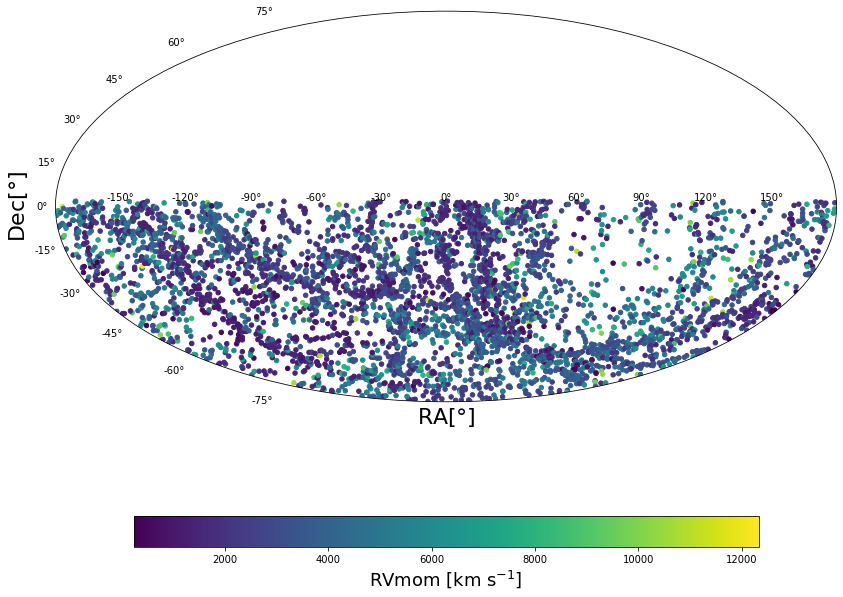

In [5]:
# Plot HIPASS survey

fig = plt.figure(figsize=(14,14))
# Using mollweide projection
ax = fig.add_subplot(111, projection="mollweide") 
# Converting RA and DEC from deg to radians
im = ax.scatter(np.radians(df_hipass['_RAJ2000']-180), np.radians(df_hipass['_DEJ2000']), c=df_hipass['RVmom'], cmap='viridis', s=20)
# Adding colorbar for the sources, based on their Velocity
cb = plt.colorbar(im, orientation = 'horizontal', shrink = 0.8)
# RVmom ==> Flux-weighted mean velocity of profile clipped at RVlo and RVhi (explained in the online HIPASS table)
cb.set_label(r'RVmom [km s$^{-1}$]', size=18) 

# Add axis labels and label sizes
ax.set_xlabel(r'$\mathrm{RA[\degree]}$')
ax.xaxis.label.set_fontsize(22)
ax.set_ylabel(r'$\mathrm{Dec[\degree]}$')
ax.yaxis.label.set_fontsize(22)

# Invalid value encountered probably because of x limits are +/- Pi which are both singularities on the Mollweide projection.

<a class="anchor" id="chapter1.2"></a>
# Choose dataset to visualise
### Default 'selected = 'most_massive' - the selected dataset is 'most_massive' and 'Number_of_sources = 10' which selects 10 galaxies
Please be aware that depending on the internet, you might need a long time to proccess the notebook with large number of galaxies.
max(Number_of_sources) for confused sources is 333; otherwise it is 4315

In [6]:
Number_of_sources = 10

# Assign only one of the following: 'most_massive', 'least_massive', 'confused'

selected = 'most_massive'

# For example, if selected = 'most_massive' it will compute sub-sample of the X most massive galaxies, where X
# is the Number_of sources; if you type selected = 'least_massive' it will do the same for the X least massive sources

In [7]:
# Report an error if 'selected' is wrong

possible_selection = set(['most_massive', 'least_massive', 'confused'])

if selected not in possible_selection:
    print('There is an error in your selection. Please check \'selected\' in the cell above.')

In [8]:
# Create a dictionary with possible selections 
select_dict = {
  'most_massive' : (False, 'logHI_mass_approx'),
  'least_massive' : (True, 'logHI_mass_approx'),
  'confused' : (False, 'cf')
}

### Set saving folders

If they don't exist yet, create on VOSpace the directories needed to save the HI spectra and optical images.
The name of the directories will contain the _selected_ dataset.

In [9]:
spectra_path = 'vos://HIPASS_spectra_%s/' % str(selected)
images_path = 'vos://HIPASS_images_%s/' % str(selected)

if sc.stat(spectra_path) == {}:
    sc.mkdir(spectra_path)

if sc.stat(images_path) == {}:
    sc.mkdir(images_path)

interactive = selected

### Create the dataframe based on the selected conditions

In [10]:
H0 = 70 # Hubble constant
# Add distance HI mass to the table
# These are created by addopting RVmom as the recessional velocity for distance (RVmom * H0) and mass estimation! 
df_hipass['logHI_mass_approx'] = pd.Series(np.log10(2.365*10e5*((df_hipass['RVmom']/H0)**2)*df_hipass['Sint']), index=df_hipass.index)
df_hipass['Distance_approx'] = pd.Series( (df_hipass['RVmom']/H0), index=df_hipass.index)

# Check selected conditions and use parameters from the dictionary to sort/select correct sub-dataset
ascending_ = select_dict[selected][0]
by_ = select_dict[selected][1]

# Create sorted (based on the dataset selected above) pandas dataframe
#df_selected = df_hipass.sort_index(by=by_, ascending = ascending_).reset_index() #Creating selected dataset and sorting
df_selected = df_hipass.sort_values(by_, ascending = ascending_).reset_index() #Creating selected dataset and sorting
df_selected = df_selected[0:Number_of_sources] # Getting the specific number of sources
df = df_selected # Save new dataframe

In [11]:
# Display the sorted dataframe head to see partial content
df.head()

,index,_RAJ2000,_DEJ2000,HIPASS,RAJ2000,DEJ2000,RV50max,RV50min,RV20max,RV20min,...,Sigma,Boxsize,Qual,nb,cf,ext,Spectrum,SimbadName,logHI_mass_approx,Distance_approx
0,1522,129.175417,-43.635278,b'J0836-43 ',b'08 36 42.1',b'-43 38 07',10710.2,10448.9,10688.7,10476.0,...,158,28,1,0,0,0,b'Spectrum',b'HIPASSJ0836-43 \r',11.936460,153.021429
1,3658,293.791667,1.236944,b'J1935+01 ',b'19 35 10.0',b'+01 14 13',10038.8,10038.8,10063.8,10063.8,...,158,28,1,0,0,0,b'Spectrum',b'HIPASSJ1935+01 \r',11.837610,143.641429
2,1249,104.032500,-36.950000,b'J0656-36 ',b'06 56 07.8',b'-36 57 00',9509.1,9509.1,9513.5,9513.5,...,158,28,1,0,0,0,b'Spectrum',b'HIPASSJ0656-36 \r',11.835046,135.724286
3,3501,274.068333,-49.781389,b'J1816-49 ',b'18 16 16.4',b'-49 46 53',10154.2,10154.2,10179.7,10179.7,...,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ1816-49 \r',11.834690,145.234286
4,3877,314.452917,-43.375556,b'J2057-43 ',b'20 57 48.7',b'-43 22 32',9246.3,8959.5,9245.2,9245.2,...,158,28,1,1,0,0,b'Spectrum',b'HIPASSJ2057-43 \r',11.831974,131.925714


<a class="anchor" id="chapter1.3"></a>
## Scraping url-s where the data of the HIPASS spectra is storred

In [12]:
# Edit url for each galaxy in HIPASS: for making url-s we need: RA, DEC, and a number of the cube from where data was extracted
# Needed data are provided in the HIPASS table: df['RAJ2000'], df['DEJ2000'] and df['cube']

# List of url-s
all_s = [] 
# Go through each galaxy from the dataframe
for galaxy in tqdm(range(df.index[0], df.index[0]+len(df))):
    
    # Cube string can be example 9(99) from table, however, for url request they need to be written as 009(099)
    # We check the cube number length and add 00(0) if needed.
    
    if len(str(df['cube'][galaxy]))==1:
        cube = ('00'+ str(df['cube'][galaxy]))
    elif len(str(df['cube'][galaxy]))==2:
        cube = ('0'+ str(df['cube'][galaxy]))
    else:
        cube = (str(df['cube'][galaxy]))
    
    # Combine all aquired strings into the uls string which is constant and append it to `all_s`
    s = ('http://www.atnf.csiro.au/cgi-bin/multi/release/download.cgi?cubename=/var/www/vhosts/www.atnf.csiro.au/'+
     'htdocs/research/multibeam/release/MULTI_3_HIDE/PUBLIC/H'+
     '{0}_abcde_luther.FELO.imbin.vrd&hann=1&coord={1}%3A{2}%3A{3}%2C{4}%3A{5}%3A{6}&xrange=-1281%2C12741&xaxis=optical&datasource=hipass&type=ascii'.format( 
         str(cube),  
         str(df['RAJ2000'][galaxy])[2:4], str(df['RAJ2000'][galaxy])[5:7], 
         str(df['RAJ2000'][galaxy])[8:10], str(df['DEJ2000'][galaxy])[2:5], str(df['DEJ2000'][galaxy])[6:8], str(df['DEJ2000'][galaxy])[9:11] ) )
    all_s.append(s) # Store each url to the 'all_s'

100%|██████████| 10/10 [00:00<00:00, 2910.08it/s]


<a class="anchor" id="chapter1.4"></a>
##  Creating list of HIPASS sources

In [13]:
# Extract the HIPASS source names from the table; String manipulation is needed to strip certain characters from name 
# Also, each source has sting `HIPASS` in front of its table name, so we add that

# Creating HIPASS sources name list
HIPASS_sources = []

for galaxy_name in range(df.index[0], df.index[0]+len(df)):
    gal_name = str(df['HIPASS'][galaxy_name]).strip('b\' ')
    HIPASS_sources.append('HIPASS'+gal_name)

<a class="anchor" id="chapter1.5"></a>
## Extracting spectral information from the HIPASS database

In [14]:
# We want to go to each url and extract only the spectra data
# From each url we need Intensity, Velocity and Channel information

#Storring values
Intensity = []
Velocity = []
Channel = []

# Going through each url, reading it with the BeautifulSoup and manipulating to get needed data
count = -1
for each_galaxy in tqdm(all_s):    
    count += 1
    res = requests.get(each_galaxy)
    soup = BeautifulSoup(res.content,'lxml')
    
    # Take a part of the url page where the spectral information is held
    # This requires skipping first 1510 characters and everything after 50176 character from the url 
    # These numbers are always the same for the HIPASS database
    
    start_df = str(soup)[1510:]  # Starting character 
    for_table = start_df[:50176] # Remove everything after this character (</p></body></html>)
    
    # Split data into rows with separator '\n' 
    a = for_table.rstrip().split('\n')
    
    # Go line by line and extract string which are actually numbers (3 columns: Channel, Velocity and Intensity)
    Chan = []
    Vel = []
    Int = []
    # We know where the required informations are storred so we are just extracting certain characters
    # This information for the channel/velocity and intensity is always the same at the HIPASS database
    for i in a:
        Chan.append(i[1:12])
        Vel.append(i[17:33])
        Int.append(i[36:49])
        
    # Convert string into floats and save them for each galaxy
    I = [float(i) for i in Int]
    C = [float(i) for i in Chan]
    V = [float(i) for i in Vel]
    
    # Store all information for each galaxy as: Intensity, Velocity and Channel
    Intensity.append(I)
    Velocity.append(V)
    Channel.append(C)
    

100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


<a class="anchor" id="chapter1.6"></a>
## Plotting the HI spectra for each source

In [15]:
# Plot the spectra of all sources and save files in a subdirectory - these will be used for interactive examination
# For each source that was extracted
store_indices = []
for idx, i in enumerate(range(len(Velocity))):
    store_indices.append(idx)
    fig = plt.figure(figsize=(8,7))                                                               
    ax = fig.add_subplot(1,1,1)
    
    # Plotting Velocity and HI intensity
    plt.plot(Velocity[i], Intensity[i], 'k', linewidth = 1, label=str(df['HIPASS'][i]).strip('b\' ') )
    # Read the position where HI is detected (information from the table)
    # Adding by default velocity +- from the center of the detected source velocity
    # Range can be arbitrary as the velocity information for each source is in range from around -1280 to around 12726 km/s
    plt.xlim(df['RV1'][i]-500, df['RV2'][i]+500) 
    
    # Adding span in which HI spectrum was integrated to get the flux values
    ax.axvspan(df['RV1'][i], df['RV2'][i], ymin=0, ymax=1, alpha=0.5, color='lightgrey') # Shade spectra region
    
    # Add limits to plot, labels, ticks and save figure
    # For limits on y-axis, use Speak
    plt.ylim(-0.05, df['Speak'][i]+0.03)
    
    # Add axes names
    plt.ylabel('Flux density [Jy beam$^{-1}$]', fontsize = 15)
    plt.xlabel('Optical Velocity [km s$^{-1}$]', fontsize = 15)
    # Specify properties of the axes and their ticks
    ax.get_yaxis().set_tick_params(which = 'both', direction='in', right = True, size = 13)
    ax.get_xaxis().set_tick_params(which = 'both', direction='in', top = True, size = 13)
    # Plot legend
    plt.legend(loc=1, fontsize=20)

    # Save plots in the spectra_path as numbered from 0000 , using this format because it's needed for files to be sorted
    # Default names will be from 0000 up to 0009 - 10 files selected; 
    
    fname = 'hipass_{0:04d}.png'.format(idx)
    fig.savefig(fname)
    # Put the giles into VOSpace and remove from the local dir
    sc.put(fr = fname, to = spectra_path+fname)
    
    plt.close(fig)

(1 / 1) hipass_0000.png -> vos://HIPASS_spectra_most_massive/hipass_0000.png
(1 / 1) hipass_0001.png -> vos://HIPASS_spectra_most_massive/hipass_0001.png
(1 / 1) hipass_0002.png -> vos://HIPASS_spectra_most_massive/hipass_0002.png
(1 / 1) hipass_0003.png -> vos://HIPASS_spectra_most_massive/hipass_0003.png
(1 / 1) hipass_0004.png -> vos://HIPASS_spectra_most_massive/hipass_0004.png
(1 / 1) hipass_0005.png -> vos://HIPASS_spectra_most_massive/hipass_0005.png
(1 / 1) hipass_0006.png -> vos://HIPASS_spectra_most_massive/hipass_0006.png
(1 / 1) hipass_0007.png -> vos://HIPASS_spectra_most_massive/hipass_0007.png
(1 / 1) hipass_0008.png -> vos://HIPASS_spectra_most_massive/hipass_0008.png
(1 / 1) hipass_0009.png -> vos://HIPASS_spectra_most_massive/hipass_0009.png


<a class="anchor" id="chapter2"></a>
# Query optical counterparts of the HIPASS sources
<a class="anchor" id="chapter2.1"></a>
### Create a list of coordinates

In [16]:
# To query Sky position (images) of sources, we need central position of each detection in HIPASS so we extract them using SkyCoord
c = []
for each_galaxy in df.index:
    center = SkyCoord(df['_RAJ2000'][each_galaxy], df['_DEJ2000'][each_galaxy], frame='icrs', unit="deg")
    c.append(center)

<a class="anchor" id="chapter2.2"></a>
## Download and save images from SkyView
### (Depending on the internet this cell takes longer to run. ~500 sources takes around 1h)

In [17]:
TIMEOUT_SECONDS = 36000
# Get image from the SkyView based on the position
# Radius of the extracted images is matched to the HIPASS primary beam (~15 arcmin)
# Attention --- Not all HIPASS sources are clearly identified, since the beam is 15 arcmin there are confused sources - thus
# possible optical counterpart will be off center in the optical image

for idx, each_galaxy in enumerate(HIPASS_sources):

# Encountering  HTTPError when the position of the source is not in the image database, then it will be skipped and user will be notified   
    try:
        # Get coordinates
        center = (c[idx])
        
        # Get image from the SkyView based on coordinates; radius is matched to HIPASS primary beam
        # You can check all other available surveys: SkyView.list_surveys() 
        # HIPASS survey is Souther Sky survey, DSS has full coverage, using other Surveys may return empty images
        Survey = 'DSS'
        # 15 arcmin radius to match the HIPASS primary beam radius. HIPASS detection is within 15arcmin.
        # To better see galaxies, we can place less than 15arcmin
        images = SkyView.get_images(position=center, pixels=[500,500], survey=Survey, radius=15*u.arcmin)
        
        image = images[0]
        
        # 'imgage' is now a fits.HDUList object; the 0th entry is the image
        mywcs = wcs.WCS(image[0].header)
        
        fig = plt.figure(figsize=(8,8))
        fig.clf() # just in case one was open before
        
        # use astropy's wcsaxes tool to create an image with RA/DEC on axis
        ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)
        
        ax.set_xlabel("RA", fontsize=15)
        ax.set_ylabel("Dec", fontsize=15)
        
        # Show image
        ax.imshow(image[0].data, cmap='gray_r', interpolation='none', origin='lower',
                  norm=plt.matplotlib.colors.LogNorm())
        matplotlib.rcParams.update({'font.size': 22})
        # Save optical image
        # Save plots in the imqt3w_path as numbered from 0000 , using this format because it's needed for files to be sorted
        # Default names will be from 0000 up to 0009 - for 10 selected files; 
    
        fname = 'hipass_{0:04d}.png'.format(idx)
        fig.savefig(fname)
        # Put the giles into VOSpace and remove from the local dir
        sc.put(fr = fname, to = images_path+fname)
        !rm -f hipass_*.png
        
        plt.close(fig)
        
    except HTTPError:
        print('Image not found in the {0} filter'.format(Survey))
        continue

(1 / 1) hipass_0000.png -> vos://HIPASS_images_most_massive/hipass_0000.png
(1 / 1) hipass_0001.png -> vos://HIPASS_images_most_massive/hipass_0001.png
(1 / 1) hipass_0002.png -> vos://HIPASS_images_most_massive/hipass_0002.png
(1 / 1) hipass_0003.png -> vos://HIPASS_images_most_massive/hipass_0003.png
(1 / 1) hipass_0004.png -> vos://HIPASS_images_most_massive/hipass_0004.png
(1 / 1) hipass_0005.png -> vos://HIPASS_images_most_massive/hipass_0005.png
(1 / 1) hipass_0006.png -> vos://HIPASS_images_most_massive/hipass_0006.png
(1 / 1) hipass_0007.png -> vos://HIPASS_images_most_massive/hipass_0007.png
(1 / 1) hipass_0008.png -> vos://HIPASS_images_most_massive/hipass_0008.png
(1 / 1) hipass_0009.png -> vos://HIPASS_images_most_massive/hipass_0009.png


<a class="anchor" id="chapter3"></a>
# Setting up Bokeh for interactive examination
<a class="anchor" id="chapter3.1"></a>
### Extracting images and spectra

In [18]:
# Path to the storred images. 

vopath = relpath(expanduser('~')) + sep + 'vospace' + sep
my_im_path = vopath + 'HIPASS_images_' + str(interactive) + sep
my_sp_path = vopath + 'HIPASS_spectra_' + str(interactive) + sep

# List the files in the path where images/spectra are storred and append the VOSpace path to it (my_sp_path and my_im_path)
# All paths to files will be storred into list_spectra and list_images which will be used in bokeh.
list_spectra = []
list_images = []
for each_file in listdir(my_im_path):
    New_list_s = my_sp_path+str(each_file)
    New_list_i = my_im_path+str(each_file)
    list_spectra.append(New_list_s)
    list_images.append(New_list_i)

<a class="anchor" id="chapter4"></a>
# Interactive visualization with Bokeh

In [19]:
# Add bokeh features
# We are plotting x and y data
# As desc - description - we will have name of the object
# As spectra and imgs -- we will have spectrum image and optical image for each source as we hover above plotted points
# Depending on the speed of your internet, when first time hovering on points - wait a couple of seconds for images to appear


source = ColumnDataSource(
        data=dict(
            x = df['Distance_approx'], # x-axis on the plot
            y = df['logHI_mass_approx'], # y-axis on the plot
            z = df['W20max'], # colourbar on the plot
            desc = HIPASS_sources , # Source name in the hover
            confused = df['cf'], # Confused/Non-confused statement in the hover
            ra_obj = df['_RAJ2000'], # RA of the source in the hover
            dec_obj = df['_DEJ2000'], # DEC of the source in the hover
            spectra = list_spectra, # Spectrum image in the hover
            imgs = list_images,)) # Optical image in the hover

# Adding html code to say how the images, spectra and other information will be displayed when one hover on points
# Important things to notice here is connection to the source above. When you want to use specific item from the source, you 
# link it to the hover belov with: @item_name
# Other information is .hyml code to sort how the data will be displayed. 
# If bokeh hover tool is used without image display - .html code is not necessary.

hover = HoverTool(    tooltips="""
    <div>
        <div>
        
        </div>
            <span style="font-size: 17px; font-weight: bold; color: #c51b8a; ">@desc</span>
        </div>   
        
            <table>
            <tr>
            <td><img src="@imgs" width="350" /></td>
            <td><img src="@spectra" width="330" />                
            
            <center>
            </div>
                <span style="font-size: 12px; font-weight: bold;"> RA [deg] = @ra_obj</span>
                <br>
                <span style="font-size: 12px; font-weight: bold;"> DEC [deg] = @dec_obj</span>
            </div> 
            </center>
            </td>
            
            </tr> 
            </table>
            
            <div>
                <span style="font-size: 15px;">Location</span>
                <span style="font-size: 10px; font-weight: bold; color: #8856a7;">($x, $y )</span>

            <span style="font-size: 12px; font-weight: bold;">Confused source if=1: @confused</span>

    """
)
        
# Define figure size (width/height), assign tools (plot options, zoom, point selection, hover) and give name
p = figure(plot_width=700, plot_height=700, tools=[hover, "pan,wheel_zoom,box_zoom,reset"], 
           title="{0} galaxies from HIPASS".format(Number_of_sources), toolbar_location="above")

# Define axis labels and properties
p.xaxis.axis_label = 'Distance [Mpc]'
p.yaxis.axis_label = 'log HI Mass'
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"
p.title.text_font_size = '18pt'
p.xaxis.major_label_text_font_size = "15pt"
p.yaxis.major_label_text_font_size = "15pt"

# Use the field name of the column source. Here is specifyed what goes on the colour bar and which colour it is.
mapper = linear_cmap(field_name='z', palette=viridis(8) ,low=min(df['W20max']) ,high=max(df['W20max']))

# Plot x and y data. Link points to colourmap with mapper. Link hover to the source.
p.scatter('x', 'y', size=14,  line_color=mapper, color=mapper,  source=source, fill_alpha=0.7)

# Add colourbar to the plot.
color_bar = ColorBar(color_mapper=mapper['transform'], width=18,  location=(-2,-1), title='W20max')
p.add_layout(color_bar, 'right')

# Ticks sizes
p.axis.major_tick_out = 0
p.axis.major_tick_in = 12
p.axis.minor_tick_in = 6
p.axis.minor_tick_out = 0

# Save as html file into VOSpace and then open in browser to visualize
output_file('HIPASS_interactive_'+str(interactive)+'.html', mode='inline')
save(p)

# Show in interactive plot in the notebook.
try:
    show(p)
except:  # workaround for Bokeh's "single document ownership" error
    show(p)

# For better performance, open the saved .html document

<a class="anchor" id="resources"></a>
# Resources and references

#### Acknowledgements
Author would like to thank Robert Nikutta and Manodeep Sinha for their usefull comments and suggestions on this notebook.

#### The HIPASS data 
Barnes et al (http://adsabs.harvard.edu/abs/2001MNRAS.322..486B)  
Data used in this notebook are published by Meyer et al. 2004 https://ui.adsabs.harvard.edu/?#abs/2004MNRAS.350.1195M  

##### The HIPASS table 
Table is obtained through VizieR services: This research has made use of the VizieR catalogue access tool, CDS,  Strasbourg, France (DOI : 10.26093/cds/vizier). The original description of the VizieR service was published in A&AS 143, 23

The Parkes telescope is part of the Australia Telescope which is funded by the Commonwealth of Australia for operation as a National Facility managed by CSIRO. The full HI database is located here http://www.atnf.csiro.au/research/multibeam/release/

#### SkyView 
Sky View has been developed with generous support from the NASA AISR and ADP programs (P.I. Thomas A. McGlynn) under the auspices of the High Energy Astrophysics Science Archive Research Center (HEASARC) at the NASA/ GSFC Astrophysics Science Division. (https://skyview.gsfc.nasa.gov/current/cgi/survey.pl)

#### Optical images 
Obtained from Original Digitised Data Service: STScI, ROE, AAO, UK-PPARC, CalTech, National Geographic Society. (http://archive.stsci.edu/dss/copyright.html)

#### Used Python3 and Python packages:

Astropy (Astropy Collaboration, doi: 10.1051/0004-6361/201322068) https://www.astropy.org/  
Pandas The official documentation is hosted on PyData.org: https://pandas.pydata.org/pandas-docs/stable   
Bokeh : Bokeh Development Team (2018). Bokeh: Python library for interactive visualization URL http://www.bokeh.pydata.org.  
Matplotlib (Hunter el al. 2007, doi: 10.1109/MCSE.2007.55) http://matplotlib.org/  
Astroquery https://astroquery.readthedocs.io/en/latest/  
Numpy (van der Walt 2011, doi: 10.1109/MCSE.2011.37) http://www.numpy.org/  
Requests (Copyright 2018 Kenneth Reitz), https://2.python-requests.org/en/master/  
tqdm: https://github.com/tqdm  
BeautifulSoup https://www.crummy.com/software/BeautifulSoup/bs4/doc/  